# **Clustering, WEAT and Professions Test by Gonen and Goldberg (2019)**
This code block implements an `EnhancedBiasAnalyzer` class that analyzes gender bias in word embeddings by following the methodology from Gonen & Goldberg (2019). The class loads word lists for male and female-associated words, profession data, and word embeddings. It then computes gender directions (differences between male and female word embeddings) and bias scores for individual words. Additionally, it generates visualizations of the word embeddings in a 2D space using t-SNE and evaluates profession-related gender bias through clustering and analysis of nearest neighbors.

In [4]:
import os
import json
import numpy as np
import scipy.stats
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

class EnhancedBiasAnalyzer:
    def __init__(self, embedding_paths,
                 male_words_path,
                 female_words_path,
                 professions_path,
                 vec_length=300):
        """
        Initialize the EnhancedBiasAnalyzer, which computes gender bias in word embeddings
        following the methodology of Gonen & Goldberg (2019). This includes loading word lists,
        professions, and embeddings, creating limited vocabularies excluding gender-specific words,
        and computing gender directions and bias scores for each embedding.

        :param embedding_paths: Dictionary mapping embedding names to their file paths.
        :param male_words_path: File path to the list of male-associated words.
        :param female_words_path: File path to the list of female-associated words.
        :param professions_path: File path to the JSON file containing a list of professions.
        :param vec_length: Length of the embedding vectors (default is 300).
        :return: None
        """
        print("\n=== Initializing Bias Analyzer ===")
        self.embedding_vocab = {}
        self.embedding_vectors = {}
        self.embedding_word_indices = {}

        print("Loading word lists...")
        self.male_words = self._load_word_list(male_words_path)
        self.female_words = self._load_word_list(female_words_path)
        print(f"Loaded {len(self.male_words)} male words and {len(self.female_words)} female words")
        self.gender_specific = self.male_words + self.female_words

        print("Loading professions...")
        self.professions = self._load_professions(professions_path)
        print(f"Loaded {len(self.professions)} professions")

        print("\nLoading embeddings...")
        for name, path in tqdm(embedding_paths.items(), desc="Processing embeddings"):
            self._load_and_normalize_embedding(name, path, vec_length)
            print(f"Loaded {name}: {len(self.embedding_vocab[name])} words")

        print("\nCreating limited vocabularies...")
        self._create_limited_vocabularies()

        print("\nComputing gender directions and bias scores...")
        self.gender_directions = {}
        self.gender_bias = {}
        for name in tqdm(list(self.embedding_vocab.keys()), desc="Computing bias"):
            if not name.endswith('_limited'):
                self.gender_directions[name] = self._compute_gender_direction(name)
                self.gender_bias[name] = self._compute_gender_bias(name)

        print("Initialization complete!\n")

    def _compute_gender_direction(self, embedding_name):
        """
        Compute the normalized gender direction vector by calculating the difference
        between the average embeddings of male and female-associated words.

        :param embedding_name: The name of the embedding to compute the gender direction for.
        :return: Normalized vector representing the gender direction in the embedding space.
        """
        male_vectors = []
        female_vectors = []

        for word in self.male_words:
            if word in self.embedding_word_indices[embedding_name]:
                male_vectors.append(
                    self.embedding_vectors[embedding_name][
                        self.embedding_word_indices[embedding_name][word]])

        for word in self.female_words:
            if word in self.embedding_word_indices[embedding_name]:
                female_vectors.append(
                    self.embedding_vectors[embedding_name][
                        self.embedding_word_indices[embedding_name][word]])

        male_center = np.mean(male_vectors, axis=0)
        female_center = np.mean(female_vectors, axis=0)

        gender_direction = male_center - female_center
        gender_direction = gender_direction / np.linalg.norm(gender_direction)

        return gender_direction

    def _load_word_list(self, filepath):
        """
        Load a list of words from a file, where each line in the file corresponds to a word.

        :param filepath: The file path to the word list.
        :return: List of words from the file (lowercased).
        """
        if not os.path.exists(filepath):
            print(f"Warning: File {filepath} not found!")
            return []
        with open(filepath, 'r', encoding='utf-8') as f:
            return [line.strip().lower() for line in f if line.strip()]

    def _load_professions(self, filepath):
        """
        Load a list of professions from a JSON file.

        :params filepath: The file path to the JSON file containing professions.
        :return: List of professions from the file.
        """
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
                return [item[0].strip().lower() for item in data]
        except Exception as e:
            print(f"Error loading professions: {e}")
            return []

    def _load_and_normalize_embedding(self, name, filepath, vec_length):
        """
        Load the word embeddings from a file and normalize the vectors. The vectors are
        normalized by dividing each vector by its Euclidean norm to ensure unit length.

        :param name: The name of the embedding (used for logging or reporting).
        :param filepath: The file path to the embedding file.
        :param vec_length: Length of the embedding vectors.
        :return: Normalized word embeddings.
        """
        vocab = []
        vectors = []

        with open(filepath, 'r', encoding='utf-8') as f:
            for line in tqdm(f, desc=f"Loading {name}", unit="word"):
                parts = line.strip().split()
                if len(parts) < vec_length + 1:
                    continue

                word = parts[0].lower()
                try:
                    vector = np.array([float(x) for x in parts[1:vec_length+1]])
                    vocab.append(word)
                    vectors.append(vector)
                except ValueError:
                    continue

        vectors = np.array(vectors)
        norms = np.linalg.norm(vectors, axis=1)
        vectors = vectors / norms[:, np.newaxis]

        self.embedding_vocab[name] = vocab
        self.embedding_vectors[name] = vectors
        self.embedding_word_indices[name] = {w: i for i, w in enumerate(vocab)}

    def _create_limited_vocabularies(self):
        """
        Create vocabularies excluding gender-specific words.

        :return: None
        """
        original_names = [name for name in list(self.embedding_vocab.keys())
                         if not name.endswith('_limited')]

        for name in tqdm(original_names, desc="Creating limited vocabularies"):
            limited_vocab = [w for w in self.embedding_vocab[name]
                           if w not in self.gender_specific]

            limited_vectors = np.array([self.embedding_vectors[name][self.embedding_word_indices[name][w]]
                                      for w in limited_vocab])

            self.embedding_vocab[f"{name}_limited"] = limited_vocab
            self.embedding_vectors[f"{name}_limited"] = limited_vectors
            self.embedding_word_indices[f"{name}_limited"] = {w: i for i, w in enumerate(limited_vocab)}

    def _compute_gender_bias(self, embedding_name):
        """
        Compute gender bias following paper methodology.

        :param embedding_name: The name of the embedding to compute the gender bias for.
        :return: Dictionary of words and their associated gender bias score.
        """
        gender_direction = self.gender_directions[embedding_name]

        bias_dict = {}
        vectors = self.embedding_vectors[f"{embedding_name}_limited"]
        vocab = self.embedding_vocab[f"{embedding_name}_limited"]

        for i, word in enumerate(vocab):
            bias = float(np.dot(vectors[i], gender_direction))
            bias_dict[word] = bias

        return bias_dict

    def visualize_bias_clusters(self, embedding_names, num_words=500, random_state=42):
        """
        Create side-by-side TSNE visualization of bias clusters for multiple embeddings.

        :param embedding_names: List of embedding names to visualize.
        :param num_words: The number of words to display in the visualization (default is 500).
        :param random_state: Random seed for reproducibility (default is 42).
        :return: Matplotlib figure containing the visualizations.
        """
        print("\n=== Generating Bias Cluster Visualizations ===")
        fig, axes = plt.subplots(1, len(embedding_names), figsize=(6*len(embedding_names), 5))
        if len(embedding_names) == 1:
            axes = [axes]

        for idx, name in enumerate(tqdm(embedding_names, desc="Processing embeddings")):
            print(f"\nAnalyzing {name}:")
            bias_dict = self.gender_bias[name]
            sorted_words = sorted(bias_dict.items(), key=lambda x: x[1])

            female_words = [w for w, _ in sorted_words[:num_words]]
            male_words = [w for w, _ in sorted_words[-num_words:]]
            print(f"20 Most female-biased words: {', '.join(female_words[:20])}")
            print(f"20 Most male-biased words: {', '.join(male_words[:20])}")

            all_words = female_words + male_words
            vectors = np.array([self.embedding_vectors[f"{name}_limited"][
                self.embedding_word_indices[f"{name}_limited"][w]] for w in all_words])

            tsne = TSNE(n_components=2, random_state=random_state)
            embedded = tsne.fit_transform(vectors)

            axes[idx].scatter(embedded[:num_words, 0], embedded[:num_words, 1],
                            c='blue', label='Female-biased', alpha=0.5)
            axes[idx].scatter(embedded[num_words:, 0], embedded[num_words:, 1],
                            c='red', label='Male-biased', alpha=0.5)

            interesting_words = {
                'nurse': 'blue', 'secretary': 'blue', 'receptionist': 'blue',
                'engineer': 'red', 'ceo': 'red', 'programmer': 'red'
            }

            for word in interesting_words:
                if word in all_words:
                    idx_in_list = all_words.index(word)
                    axes[idx].annotate(word,
                                     (embedded[idx_in_list, 0], embedded[idx_in_list, 1]),
                                     fontsize=8)

            axes[idx].set_title(f'{name} embeddings')
            axes[idx].legend()

        plt.tight_layout()
        return fig

    def analyze_professions(self, embedding_names, k_neighbors=100):
        """
        Analyze profession bias following paper methodology.

        :param embedding_names: List of embedding names to analyze.
        :param k_neighbors: The number of nearest neighbors to consider for each profession (default is 100).
        :return: A tuple containing a Matplotlib figure and a dictionary with correlation and p-values.
        """
        print("\n=== Analyzing Professional Biases ===")
        fig, axes = plt.subplots(1, len(embedding_names), figsize=(6*len(embedding_names), 5))
        if len(embedding_names) == 1:
            axes = [axes]

        results = {}
        for idx, name in enumerate(tqdm(embedding_names, desc="Analyzing embeddings")):
            print(f"\nAnalyzing {name}:")
            profession_data = []

            for prof in tqdm(self.professions, desc=f"Processing professions for {name}"):
                if prof not in self.embedding_word_indices[f"{name}_limited"]:
                    continue

                bias = self.gender_bias[name][prof]
                prof_vector = self.embedding_vectors[f"{name}_limited"][
                    self.embedding_word_indices[f"{name}_limited"][prof]]

                similarities = self.embedding_vectors[f"{name}_limited"].dot(prof_vector)
                most_similar = np.argsort(similarities)[::-1][1:k_neighbors+1]

                masc_neighbors = sum(1 for i in most_similar
                                   if self.gender_bias[name][
                                       self.embedding_vocab[f"{name}_limited"][i]] > 0)

                profession_data.append((prof, bias, masc_neighbors))

            X = [x[1] for x in profession_data]
            Y = [x[2] for x in profession_data]

            axes[idx].scatter(X, Y, alpha=0.5)
            axes[idx].set_xlabel('Gender bias')
            axes[idx].set_ylabel('Number of masculine neighbors')
            axes[idx].set_title(f'{name} embeddings')

            interesting_profs = ['nanny', 'dancer', 'housekeeper',
                'receptionist', 'nurse',
                'magician', 'musician', 'warden', 'archaeologist',
                'comic', 'dentist',
                'inventor', 'colonel', 'farmer', 'skipper',
                'commander', 'coach']
            for prof, bias, masc in profession_data:
                if prof in interesting_profs:
                    axes[idx].annotate(prof, (bias, masc), fontsize=8)

            correlation, p_value = scipy.stats.pearsonr(X, Y)
            results[name] = {'correlation': correlation, 'p_value': p_value}
            print(f"Correlation: {correlation:.3f} (p-value: {p_value:.3f})")

        plt.tight_layout()
        return fig, results

    def run_association_experiments(self, embedding_names):
        """
        Run association experiments following Caliskan et al. methodology.

        :param embedding_names: List of embedding names to use in the association experiments.
        :return: None
        """
        print("\n=== Running Association Experiments ===")
        A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
        B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

        experiments = [
            ('Career vs Family',
             ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career'],
             ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']),
            ('Math vs Arts',
             ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition'],
             ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']),
            ('Science vs Arts',
             ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy'],
             ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama'])
        ]

        results = {}
        for name in tqdm(embedding_names, desc="Processing embeddings"):
            print(f"\nAnalyzing {name}:")
            results[name] = []
            for exp_name, X, Y in tqdm(experiments, desc="Running experiments"):
                effect_size = self._compute_effect_size(name, A, B, X, Y)
                p_value = self._compute_p_value(name, A, B, X, Y)
                results[name].append({
                    'experiment': exp_name,
                    'effect_size': effect_size,
                    'p_value': p_value
                })
                print(f"{exp_name}:")
                print(f"  Effect size: {effect_size:.3f}")
                print(f"  p-value: {p_value:.3f}")

        return results

    def _compute_effect_size(self, embedding_name, A, B, X, Y):
        """
        Helper method to compute effect size for association experiments.

        This method calculates the effect size based on the difference in similarity
        scores between two groups of words (A and B) with respect to two target sets of words (X and Y).
        The effect size quantifies the difference in associations between these groups and target sets.

        :param embedding_name: The name of the word embedding being used.
        :param A: The first group of words to compare in the association experiment.
        :param B: The second group of words to compare in the association experiment.
        :param X: The first set of target words.
        :param Y: The second set of target words.

        :return: The computed effect size, representing the difference in associations between the two groups.
        """
        def mean_sim(w, lst):
            if w not in self.embedding_word_indices[embedding_name]:
                return 0
            w_vec = self.embedding_vectors[embedding_name][self.embedding_word_indices[embedding_name][w]]
            sims = []
            for x in lst:
                if x not in self.embedding_word_indices[embedding_name]:
                    continue
                x_vec = self.embedding_vectors[embedding_name][self.embedding_word_indices[embedding_name][x]]
                sims.append(np.dot(w_vec, x_vec))
            return np.mean(sims) if sims else 0

        a_x_sim = np.mean([mean_sim(x, A) for x in X])
        a_y_sim = np.mean([mean_sim(y, A) for y in Y])
        b_x_sim = np.mean([mean_sim(x, B) for x in X])
        b_y_sim = np.mean([mean_sim(y, B) for y in Y])

        effect_size = (a_x_sim - a_y_sim) - (b_x_sim - b_y_sim)
        return effect_size

    def _compute_p_value(self, embedding_name, A, B, X, Y, n_samples=10000):
        """
        Helper method to compute p-value for association experiments.

        This method calculates the p-value by comparing the observed effect size
        to the distribution of effect sizes obtained from randomly shuffled target sets (X and Y).
        The p-value is used to evaluate the statistical significance of the observed effect size.

        :param embedding_name: The name of the word embedding being used.
        :param A: The first group of words to compare in the association experiment.
        :param B: The second group of words to compare in the association experiment.
        :param X: The first set of target words.
        :param Y: The second set of target words.
        :param n_samples: The number of random samples (default is 10,000) to compute the p-value.

        :return: The computed p-value, representing the probability of obtaining a larger effect size by chance.
        """
        original_score = self._compute_effect_size(embedding_name, A, B, X, Y)

        all_words = X + Y
        count_larger = 0

        for _ in tqdm(range(n_samples), desc="Computing p-value", leave=False):
            np.random.shuffle(all_words)
            X_random = all_words[:len(X)]
            Y_random = all_words[len(X):]

            random_score = self._compute_effect_size(embedding_name, A, B, X_random, Y_random)
            if random_score > original_score:
                count_larger += 1

        return count_larger / n_samples


=== Initializing Bias Analyzer ===
Loading word lists...
Loaded 223 male words and 223 female words
Loading professions...
Loaded 320 professions

Loading embeddings...


Processing embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

Loading glove: 0word [00:00, ?word/s]

Loaded glove: 400000 words


Loading hard-debiased: 0word [00:00, ?word/s]

Loaded hard-debiased: 42982 words


Loading gn-glove: 0word [00:00, ?word/s]

Loaded gn-glove: 142527 words


Loading conceptnet: 0word [00:00, ?word/s]

Loaded conceptnet: 516782 words

Creating limited vocabularies...


Creating limited vocabularies:   0%|          | 0/4 [00:00<?, ?it/s]


Computing gender directions and bias scores...


Computing bias:   0%|          | 0/8 [00:00<?, ?it/s]

Initialization complete!


Generating visualizations...

=== Generating Bias Cluster Visualizations ===


Processing embeddings:   0%|          | 0/4 [00:00<?, ?it/s]


Analyzing glove:
20 Most female-biased words: bare-breasted, millerwise, lactating, schorpen, oly-2004-fhockey, ladies-in-waiting, tallchief, selecky, poetess, kuppinger, semyonova, songstress, oly-2004-fbl, proserpina, hamoaze, voluptuous, widowhood, achouri, lady-in-waiting, buxom
20 Most male-biased words: isiah, ahaz, controlled, mercenaries, johnny, start, headed, rohsh, batting, promoted, going, council, respected, government, theodore, hussain, matthew, karlheinz, scout, reille

Analyzing hard-debiased:
20 Most female-biased words: granny, bbw, redhead, erotic, slut, wifes, sexy, femdom, lingerie, spanking, bdsm, busty, vixen, naughty, femme, voyeur, mature, amatuer, bombshell, latina
20 Most male-biased words: wuhan, ordinances, maricopa, magellan, camshaft, postsecondary, recipients, malaysians, participating, parliament, aci, internally, collaborate, safety, commission, petitioned, ids, policies, arbitration, cpd

Analyzing gn-glove:
20 Most female-biased words: miscarried, 

Analyzing embeddings:   0%|          | 0/4 [00:00<?, ?it/s]


Analyzing glove:


Processing professions for glove:   0%|          | 0/320 [00:00<?, ?it/s]

Correlation: 0.797 (p-value: 0.000)

Analyzing hard-debiased:


Processing professions for hard-debiased:   0%|          | 0/320 [00:00<?, ?it/s]

Correlation: 0.754 (p-value: 0.000)

Analyzing gn-glove:


Processing professions for gn-glove:   0%|          | 0/320 [00:00<?, ?it/s]

Correlation: 0.721 (p-value: 0.000)

Analyzing conceptnet:


Processing professions for conceptnet:   0%|          | 0/320 [00:00<?, ?it/s]

Correlation: 0.824 (p-value: 0.000)
Saved profession analysis to 'profession_analysis.png'

Profession Analysis Results:

glove:
Correlation: 0.797
P-value: 0.000

hard-debiased:
Correlation: 0.754
P-value: 0.000

gn-glove:
Correlation: 0.721
P-value: 0.000

conceptnet:
Correlation: 0.824
P-value: 0.000

Running association experiments...

=== Running Association Experiments ===


Processing embeddings:   0%|          | 0/4 [00:00<?, ?it/s]


Analyzing glove:


Running experiments:   0%|          | 0/3 [00:00<?, ?it/s]

Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Career vs Family:
  Effect size: 0.165
  p-value: 0.000


Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Math vs Arts:
  Effect size: 0.067
  p-value: 0.007


Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Science vs Arts:
  Effect size: 0.069
  p-value: 0.003

Analyzing hard-debiased:


Running experiments:   0%|          | 0/3 [00:00<?, ?it/s]

Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Career vs Family:
  Effect size: 0.058
  p-value: 0.000


Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Math vs Arts:
  Effect size: 0.044
  p-value: 0.000


Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Science vs Arts:
  Effect size: 0.023
  p-value: 0.112

Analyzing gn-glove:


Running experiments:   0%|          | 0/3 [00:00<?, ?it/s]

Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Career vs Family:
  Effect size: 0.054
  p-value: 0.050


Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Math vs Arts:
  Effect size: 0.034
  p-value: 0.072


Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Science vs Arts:
  Effect size: 0.002
  p-value: 0.471

Analyzing conceptnet:


Running experiments:   0%|          | 0/3 [00:00<?, ?it/s]

Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Career vs Family:
  Effect size: 0.069
  p-value: 0.000


Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Math vs Arts:
  Effect size: 0.059
  p-value: 0.001


Computing p-value:   0%|          | 0/10000 [00:00<?, ?it/s]

Science vs Arts:
  Effect size: 0.031
  p-value: 0.007

Association Experiment Results:

glove:

Career vs Family:
Effect size: 0.165
P-value: 0.000

Math vs Arts:
Effect size: 0.067
P-value: 0.007

Science vs Arts:
Effect size: 0.069
P-value: 0.003

hard-debiased:

Career vs Family:
Effect size: 0.058
P-value: 0.000

Math vs Arts:
Effect size: 0.044
P-value: 0.000

Science vs Arts:
Effect size: 0.023
P-value: 0.112

gn-glove:

Career vs Family:
Effect size: 0.054
P-value: 0.050

Math vs Arts:
Effect size: 0.034
P-value: 0.072

Science vs Arts:
Effect size: 0.002
P-value: 0.471

conceptnet:

Career vs Family:
Effect size: 0.069
P-value: 0.000

Math vs Arts:
Effect size: 0.059
P-value: 0.001

Science vs Arts:
Effect size: 0.031
P-value: 0.007


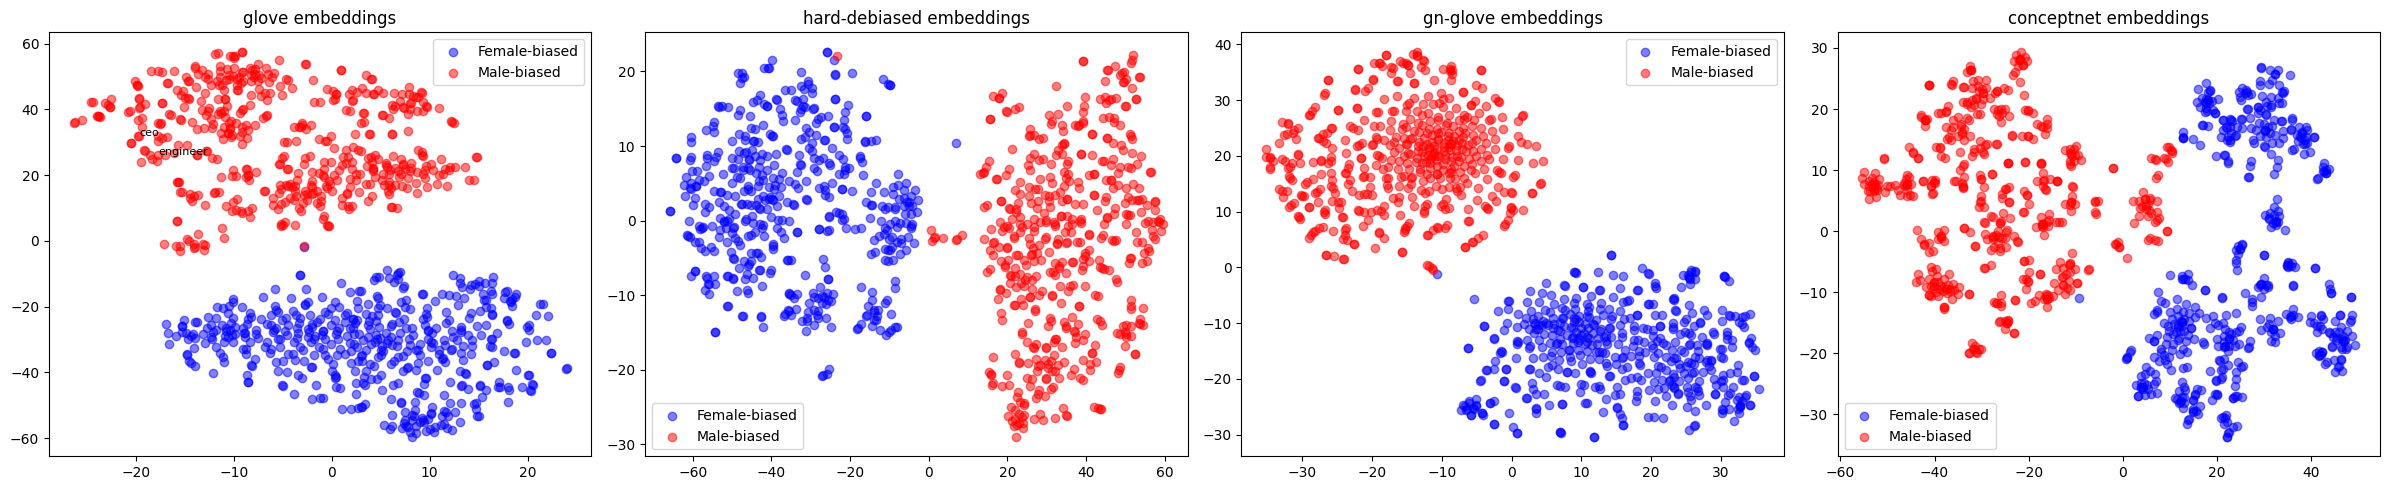

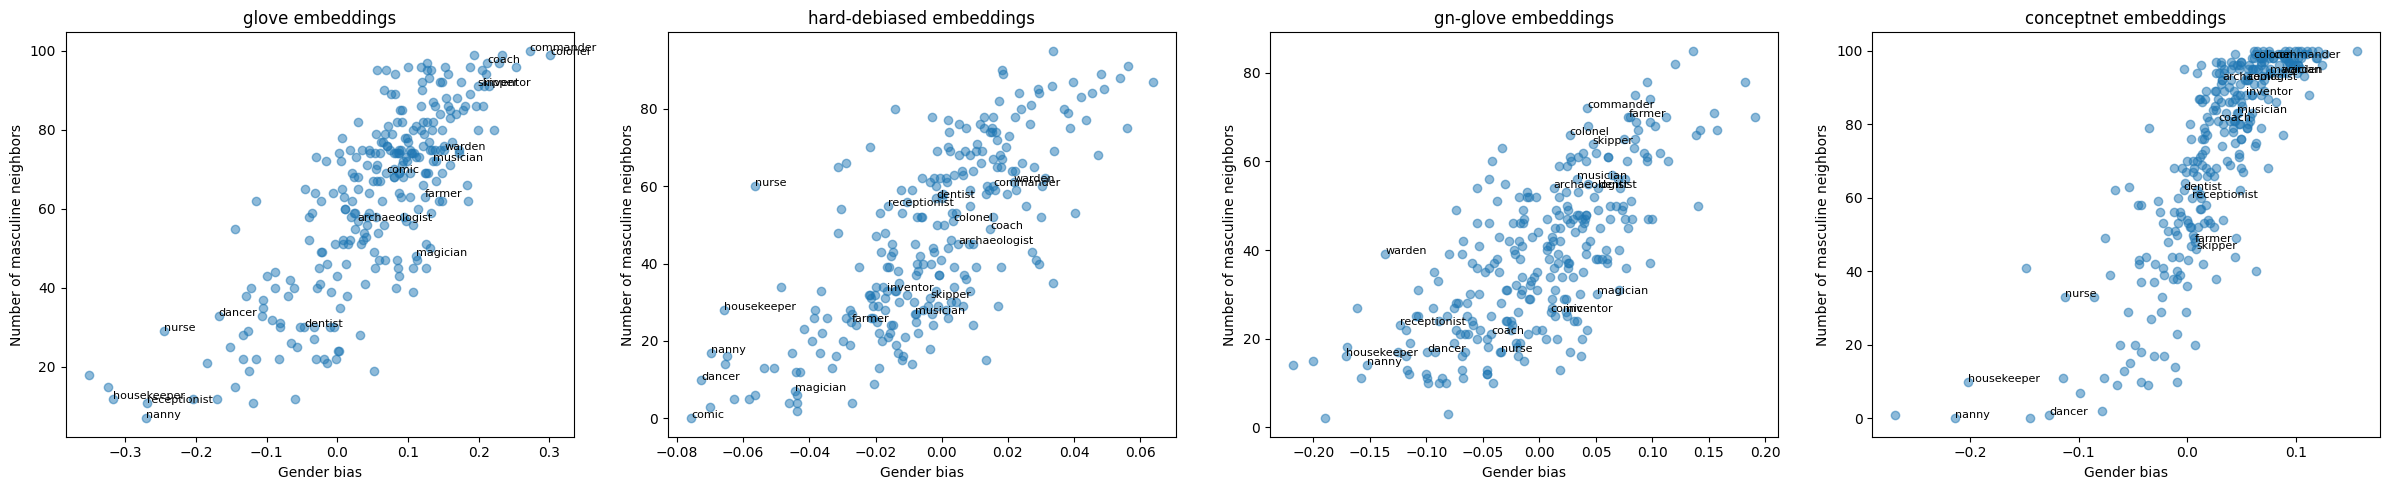

In [5]:
if __name__ == "__main__":
    embedding_paths = {
        'glove': '/content/drive/MyDrive/My_Dataset/glove.6B.300d.txt',
        'hard-debiased': '/content/drive/MyDrive/My_Dataset/glove_small_hard_debiased.txt',
        # 'GloVe-INLP': '/content/drive/MyDrive/My_Dataset/glove.42B.300d.projected.txt',
        'gn-glove': '/content/drive/MyDrive/My_Dataset/gn-glove.txt',
        'conceptnet': '/content/drive/MyDrive/My_Dataset/numberbatch-en.txt'
    }

    analyzer = EnhancedBiasAnalyzer(
        embedding_paths,
        male_words_path='/content/drive/MyDrive/My_Dataset/male_word_file.txt',
        female_words_path='/content/drive/MyDrive/My_Dataset/female_word_file.txt',
        professions_path='/content/drive/MyDrive/My_Dataset/professions.json'
    )

    print("\nGenerating visualizations...")
    bias_fig = analyzer.visualize_bias_clusters(embedding_paths.keys())
    bias_fig.savefig('bias_clusters.png')
    print("Saved bias clusters visualization to 'bias_clusters.png'")

    print("\nAnalyzing professions...")
    prof_fig, prof_results = analyzer.analyze_professions(embedding_paths.keys())
    prof_fig.savefig('profession_analysis.png')
    print("Saved profession analysis to 'profession_analysis.png'")

    print("\nProfession Analysis Results:")
    for embedding, results in prof_results.items():
        print(f"\n{embedding}:")
        print(f"Correlation: {results['correlation']:.3f}")
        print(f"P-value: {results['p_value']:.3f}")

    print("\nRunning association experiments...")
    assoc_results = analyzer.run_association_experiments(embedding_paths.keys())

    print("\nAssociation Experiment Results:")
    for embedding, results in assoc_results.items():
        print(f"\n{embedding}:")
        for experiment in results:
            print(f"\n{experiment['experiment']}:")
            print(f"Effect size: {experiment['effect_size']:.3f}")
            print(f"P-value: {experiment['p_value']:.3f}")